# Step 1: Source Data Analysis and Preprocessing

In this notebook, we explore the Amazon Customer Review dataset in order to define the data scope for building and evaluating our product search engine

In [51]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from bs4 import BeautifulSoup

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df_apparel_2015 = pd.read_csv('../resources/data/apparel_2015.tsv', sep='\t')
df_apparel_2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2355721 entries, 0 to 2355720
Data columns (total 15 columns):
 #   Column             Dtype  
---  ------             -----  
 0   marketplace        object 
 1   customer_id        int64  
 2   review_id          object 
 3   product_id         object 
 4   product_parent     int64  
 5   product_title      object 
 6   product_category   object 
 7   star_rating        float64
 8   helpful_votes      float64
 9   total_votes        float64
 10  vine               object 
 11  verified_purchase  object 
 12  review_headline    object 
 13  review_body        object 
 14  review_date        object 
dtypes: float64(3), int64(2), object(10)
memory usage: 269.6+ MB


In [8]:
df_apparel_2015.shape

(2355721, 15)

In [3]:
df_apparel_2015.head(3)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12608825,RWQEDYAX373I1,B01I497BGY,811958549,James Fiallo Men's 12-Pairs Low Cut Athletic S...,Apparel,5.000,0.000,0.000,N,Y,Great Socks for the money.,"Nice socks, great colors, just enough support ...",2015-07-12
1,US,25482800,R231YI7R4GPF6J,B01HDXFZK6,692205728,Belfry Gangster 100% Wool Stain-Resistant Crus...,Apparel,5.000,0.000,0.000,N,Y,Slick hat!,"I bought this for my husband and WOW, this is ...",2015-06-03
2,US,9310286,R3KO3W45DD0L1K,B01G6MBEBY,431150422,JAEDEN Women's Beaded Spaghetti Straps Sexy Lo...,Apparel,5.000,0.000,0.000,N,Y,I would do it again!,Perfect dress and the customer service was awe...,2015-06-12


## Check the distribution for number of reviews per product

We grouped the dataset by product, seeing the distibution on number of reviews per product. 

In [7]:
df_product_review_count = df_apparel_2015.groupby(by='product_id')['product_id'].count()
df_product_review_count = df_product_review_count.to_frame('review_count').reset_index()

In [12]:
df_product_review_count.head(3)

,product_id,review_count
0,0000032034,7
1,0000032050,7
2,0000032069,1


In [10]:
df_product_review_count['review_count'].describe()

count   1119057.000
mean          2.105
std           4.912
min           1.000
25%           1.000
50%           1.000
75%           2.000
max         646.000
Name: review_count, dtype: float64

In [11]:
df_product_review_count['review_count'].value_counts(bins=100)

(0.354, 7.45]      1080749
(7.45, 13.9]         23362
(13.9, 20.35]         7539
(20.35, 26.8]         2576
(26.8, 33.25]         1682
                    ...   
(497.65, 504.1]          0
(504.1, 510.55]          0
(510.55, 517.0]          0
(394.45, 400.9]          0
(517.0, 523.45]          0
Name: review_count, Length: 100, dtype: int64

array([[<Axes: title={'center': 'review_count'}>]], dtype=object)

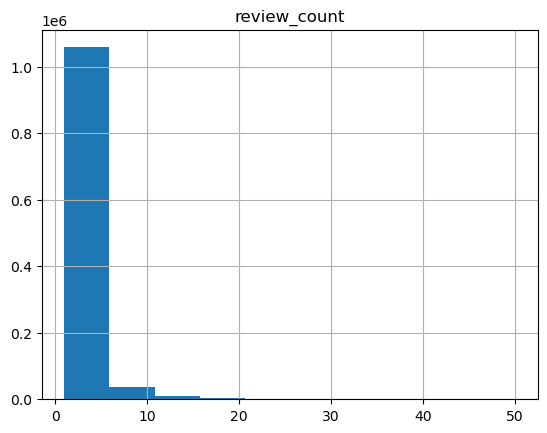

In [23]:
df_product_review_count[df_product_review_count['review_count'] <= 50].hist()

array([[<Axes: title={'center': 'review_count'}>]], dtype=object)

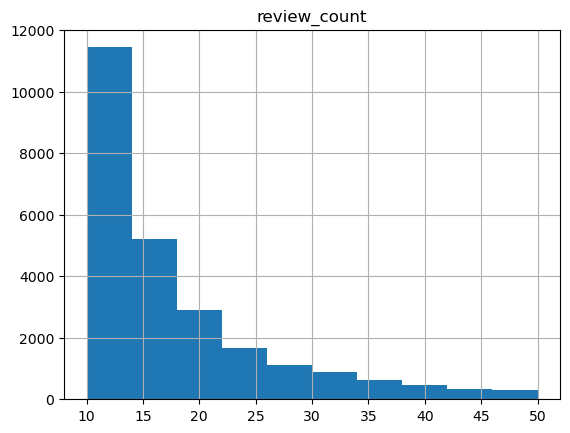

In [32]:
df_product_review_count[(df_product_review_count['review_count'] >=10) & (df_product_review_count['review_count'] <=50)].hist()

#### Observeration 
1. Majority of the products (~1M+) has reviews between 1 to 5
2. ~11.5k products has reviews between 10 to 14
3. ~10k products has reviews between 15 to 25

We decided to use products with 15 to 25 reviews as our development dataset, and use products with 10 to 14 reviews as our evaluation set

## Clean the product reviews and save the development and evaluation datasets

### Prepare the development dataset
Product with 15 to 25 number of reviews

In [42]:
df_product_review_count_15to25 = df_product_review_count[df_product_review_count['review_count'].between(15, 25,  inclusive='both')]
df_apparel_15to25 = df_apparel_2015.merge(right=df_product_review_count_15to25, how='right', left_on='product_id', right_on='product_id')

In [43]:
# remove records with reviews less than 10 words since those review are too short to much useful information  
df_apparel_15to25 = df_apparel_15to25[df_apparel_15to25['review_length'] > 10]

In [44]:
#We noticed some of the product titles and product reviews data contain HTML. We will use BeautifulSoup to clean the data before save. 
df_apparel_15to25['product_title'] = df_apparel_15to25['product_title'].apply(lambda x: BeautifulSoup(x).get_text())
df_apparel_15to25['review_body'] = df_apparel_15to25['review_body'].apply(lambda x: BeautifulSoup(x).get_text())

In [49]:
df_apparel_15to25.shape

(89103, 17)

In [ ]:
# uncomment below line in order to save the resultset
# df_apparel_15to25.to_csv('../resources/data/apparel_15to25.tsv.gz', sep='\t', index=False, compression="gzip")

### Prepare the evaluation dataset
Product with 10 to 14 number of reviews

In [46]:
df_product_review_count_10to14 = df_product_review_count[df_product_review_count['review_count'].between(10, 14,  inclusive='both')]
df_apparel_10to14 = df_apparel_2015.merge(right=df_product_review_count_10to14, how='right', left_on='product_id', right_on='product_id')

In [47]:
# remove records with reviews less than 10 words since those review are too short to much useful information  
df_apparel_10to14 = df_apparel_10to14[df_apparel_10to14['review_length'] > 10]

In [48]:
#We noticed some of the product titles and product reviews data contain HTML. We will use BeautifulSoup to clean the data before save. 
df_apparel_10to14['product_title'] = df_apparel_10to14['product_title'].apply(lambda x: BeautifulSoup(x).get_text())
df_apparel_10to14['review_body'] = df_apparel_10to14['review_body'].apply(lambda x: BeautifulSoup(x).get_text())

In [50]:
df_apparel_10to14.shape

(88918, 17)

In [ ]:
# uncomment below line in order to save the resultset
#df_apparel_10to14.to_csv('../resources/data/apparel_10to14.tsv.gz', sep='\t', index=False, compression="gzip")